
# Project 2: swarming behavior and correlated velocities

In this project you will explore the properties of the [Vicsek swarming model](https://en.wikipedia.org/wiki/Vicsek_model) and you will generalize it by adding rules to the interactions of the active particles in the system.

The model has an internal noise parameter ("$eta$" in the implementation below), and it is known that increasing $eta$ from $0$ to $1$ will lead the swarm to undergo a phase transition, i.e. a qualitative change of behavior, which in this case manifests itself as a passage from collective, ordered motion to random motion for the active particles. 

Referring to the concepts of polarization, correlation function, and correlation length defined in the article [Scale-free correlations in starling flocks](https://www.pnas.org/content/107/26/11865), answer the following questions:


(1) Estimate the value of $eta$ for which there is a phase transition in the Vicsek model, by using the polarization $\Phi$ of the system. Test your method for several values of size $N$ of the system, and several choices of initial random distributions of the active particles.


(2) Estimate the correlation function $C(r)$ of fluctuations of velocities within the Vicsek model, for multiple values of $eta$ and for $N \approx 10^3$. Estimate $\bar r$, the value of $r$ for which $C(r)$ becomes zero ($\bar r$ is an estimate of the correlation length of the swarm). 


(3) Research the literature to find other swarming and flocking models. On the basis of your literature review and your intuition, try to modify the Vicsek model so that you increase the average value of $\bar r$ for the swarm.  

N.B. all your answers should be in reference to the system in an "asymptotic" state when the initial random distribution of the positions and velocities of the active particles is no more significant to the dynamics.



This code template is taken from a blog post of [Francesco Turci](https://francescoturci.net/2020/06/19/minimal-vicsek-model-in-python/), a researcher in disordered systems. This specific Python implementation allows you to simulate far more active particles than it would be possible with a direct, naive implementation of the Vicsek model.

In [1]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

L = 32.0
rho = 3.0
N = int(rho*L**2)
print(" N",N)
 
r0 = 1.0
deltat = 1.0
factor =0.5
v0 = r0/deltat*factor
iterations = 10000
eta = 0

pos = np.random.uniform(0,L,size=(N,2))
orient = np.random.uniform(-np.pi, np.pi,size=N)

 N 3072


In [2]:
def Vicsek():
    global pos
    global orient
    global iterations  
    
    tree = cKDTree(pos,boxsize=[L,L])
    dist = tree.sparse_distance_matrix(tree, max_distance=r0,output_type='coo_matrix')
 
    #important 3 lines: we evaluate a quantity for every column j
    data = np.exp(orient[dist.col]*1j)
    # construct  a new sparse marix with entries in the same places ij of the dist matrix
    neigh = sparse.coo_matrix((data,(dist.row,dist.col)), shape=dist.get_shape())
    # and sum along the columns (sum over j)
    S = np.squeeze(np.asarray(neigh.tocsr().sum(axis=1)))
    
    for i in range(iterations):
        
        orient = np.angle(S)+eta*np.random.uniform(-np.pi, np.pi, size=N)
        
        cos, sin= np.cos(orient), np.sin(orient)
        pos[:,0] += cos*v0
        pos[:,1] += sin*v0

        pos[pos>L] -= L
        pos[pos<0] += L
    
    return pos, orient

In [3]:
def Polarization(orient, N):
    #orient = np.absolute(orient) (Do we take the absolute value?)
    v = (np.cos(orient), np.sin(orient))
    v_sum = np.sum(v, axis=1)
    v_mod = v_sum * (1/N)
    phi = np.linalg.norm(v_mod)
    return phi

<IPython.core.display.Javascript object>


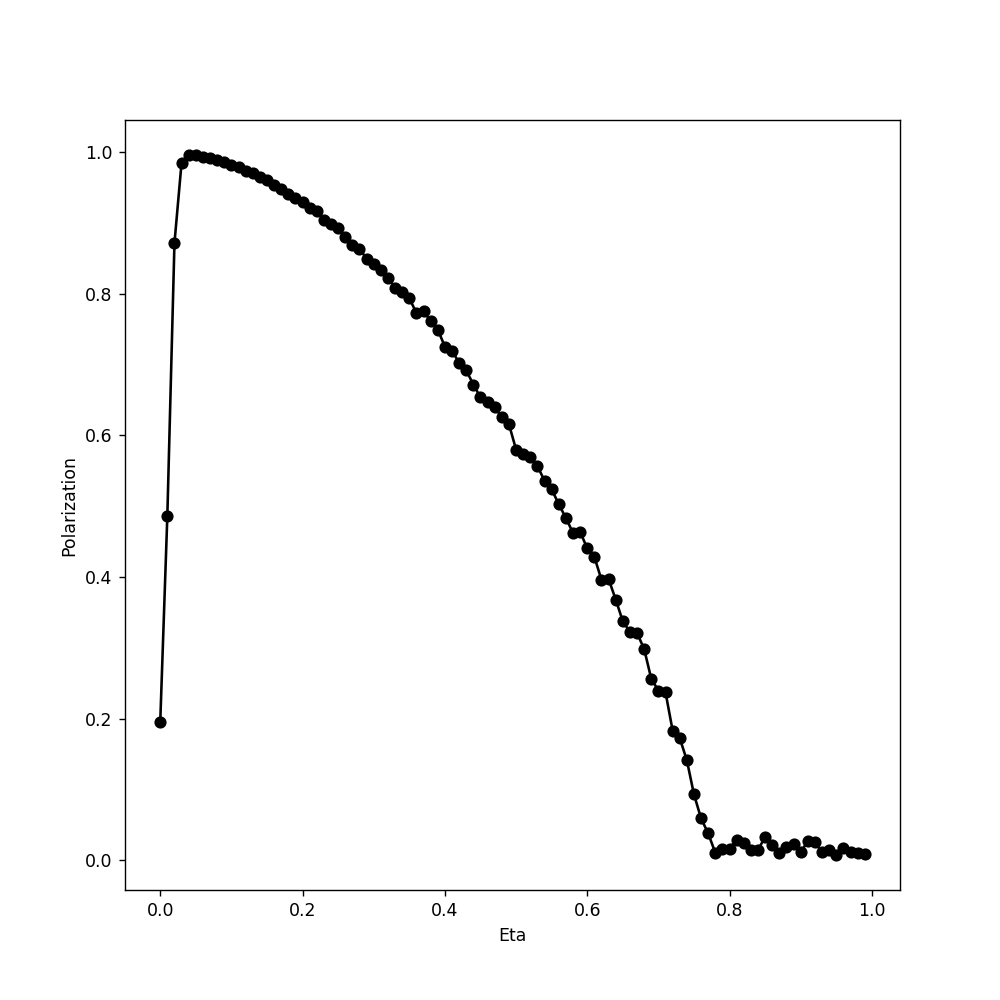

After: 0.07495583284554488


In [4]:
times = 100
polarization_points = np.zeros(times)
eta_values = np.zeros(times)
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8))

pos, orient = Vicsek()
print("After:",Polarization(orient, N))

for i in range(times):
    pos, orient = Vicsek()
    polarization_points[i] = Polarization(orient, N)
    eta_values[i] = eta
    eta += 0.01

plt.xlabel("Eta")
plt.ylabel("Polarization")
ax1.plot(eta_values, polarization_points, "ro-", color = "black")

#Note: Unsure why the graph seems to rise from 0 at the initial values of eta before spiking up to 1, as it should be initially at 1 when eta = 0

Phase Shift Research:

-Polarization should be treated as a sine function with the formula y = A sin(B(x + C)) + D, where A = Amplitude, B = Period, C = Phase Shift, and D = Vertical Shift

-If we can calculate A, B, and D using the points on the graph, we can solve for C and get the point where the phase shift occurs

-We can then write code to calculate this for each value of N we input into the system
